This is a basic implementation of Variational Autoencoders done by the UVICAI club. We hope to cover the concepts of both this architecture as well as the implementation steps in as much detail as possible. ![index.png](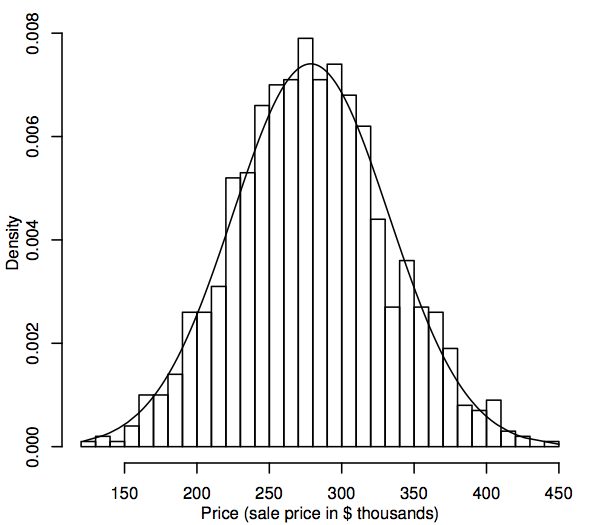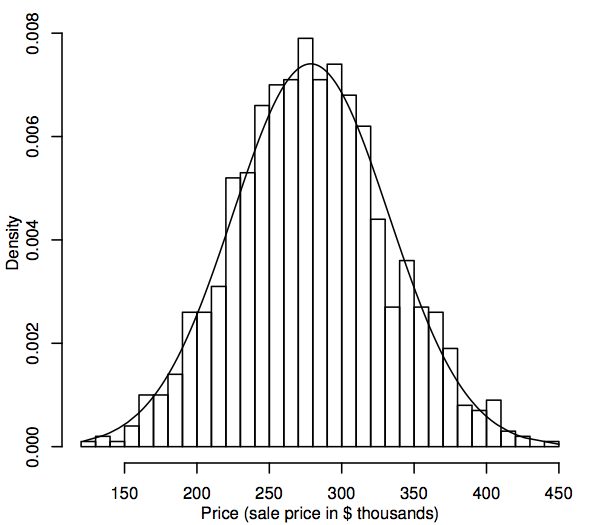)

# Step 1: Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We'll introduce the vae architecture with the dataset **MNIST**, which is called the "hello world" of machine learning due to it's simplicity and ease. MNIST consists of thousands of handwritten digits, each a 28x28 pixel grayscale image, making it an ideal starting point for exploring complex concepts in a more approachable way. To read more about the dataset, click [this link](http://yann.lecun.com/exdb/mnist/)

11490434/11490434 [==============================] - 1s 0us/step
The amount of samples we have in our training set is: 60000


Text(0.5, 1.0, 'Example of MNIST Sample')

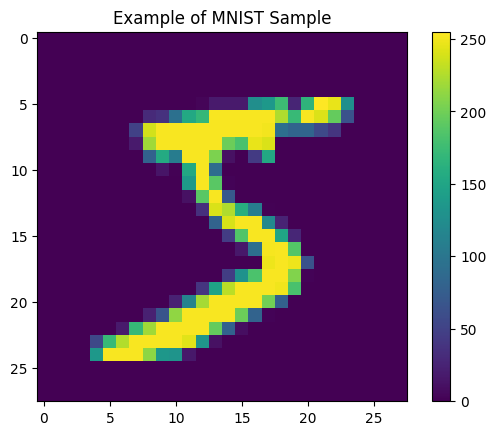

In [ ]:
# Load in the MNIST dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Show number of samples
print("The amount of samples we have in our training set is:", train_X.shape[0])

# Show example of one sample
fig, ax = plt.subplots(1,1)
ex = ax.imshow(train_X[0])
plt.colorbar(ex)
ax.set_title("Example of MNIST Sample")

# Step 2: Data Preprocessing

Mnist doesn't require to many preprocessing steps, which was one of it's key features. There are a few things we want to do however to make the samples easier to work with.

## 2.1 Normalize Dataset

Text(0.5, 1.0, 'Showcasing Difference in Scale')

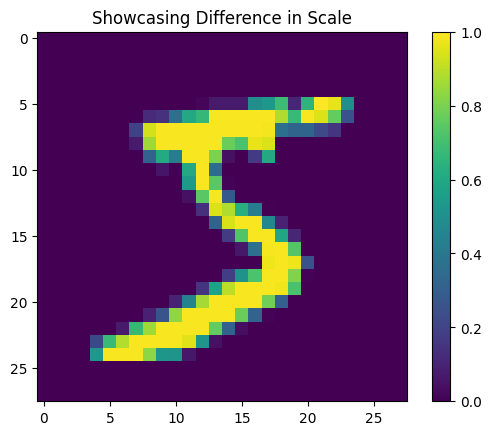

In [ ]:
train_X = train_X/255.0
test_X = test_X/255.0

# Show example of one sample
fig, ax = plt.subplots(1,1)
ex = ax.imshow(train_X[0])
plt.colorbar(ex)
ax.set_title("Showcasing Difference in Scale")

## 2.2 Breaking Datasets into Batches

In [ ]:
batch_size = 64

num_batches = train_X.shape[0]//batch_size

batches = train_X[:num_batches * batch_size].reshape(num_batches, batch_size,
                                                                train_X.shape[1], train_X.shape[2], 1)

print(batches.shape)
print("We now have", batches.shape[0], "batches of", batch_size, "samples.")

(937, 64, 28, 28, 1)
We now have 937 batches of 64 samples.


# 3. Model

This is where we begin to talk about the variational autoencoder architecture.

As we've previously discussed, variational autoencoders are a subclass of autoencoders which force the latent space to fit a continuous probability distribution.

One can think this akin to making a bellcurve line of best fit after sampling a population a certain number of times.

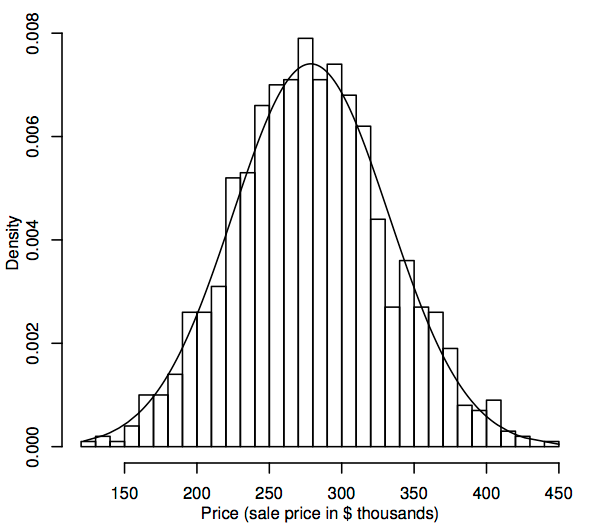

*Photo from https://online.stat.psu.edu/stat462/node/249/*


By building this model, we can start to associate any sample with where it fits on this distribution we've built. As the model starts to understand how to differentiate between different places on the distribution, we can also begin to sample from the distribution directly, generating new samples we've not seen before.

VAE's force the latent space to fit a standard normal distribution.

Before getting into the full code, let's look at the structure of the class.

In [ ]:
class VariationalAutoencoder():
    """
    A Variational Autoencoder (VAE) class for generating and modeling data.

    This class implements a VAE which is a type of generative model that learns
    a latent representation of the input data. It's useful in data generation,
    compression, and denoising.

    Attributes:
        model: The underlying neural network model for the VAE.
        encoder: The encoder part of the VAE that maps inputs to the latent space.
        decoder: The decoder part of the VAE that reconstructs inputs from the latent space.
    """

    def __init__(self):
        """
        Initializes the Variational Autoencoder class.

        This constructor typically initializes the architecture of the VAE, including
        the encoder and decoder components. Hyperparameters for the model can also be set here.
        """
        pass

    def _build_encoder(self):
        """
        Constructs the encoder part of the VAE model.

        This private method is responsible for building the encoder architecture of the VAE.
        The encoder is designed to map input data to a latent space, typically involving
        layers that progressively downsample the input data.

        Returns:
            The constructed encoder model as a neural network layer or module.
        """
        pass

    def _build_decoder(self):
        """
        Constructs the decoder part of the VAE model.

        This private method is responsible for building the decoder architecture of the VAE.
        The decoder takes a latent space representation and reconstructs the original input data,
        typically involving layers that progressively upsample the latent representation.

        The architecture of the decoder usually mirrors the encoder in a symmetrical fashion.

        Returns:
            The constructed decoder model as a neural network layer or module.
        """
        pass

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x: Input data for which the VAE needs to generate an output.

        Returns:
            The reconstructed output from the decoder after the input has been
            encoded to the latent space and then decoded back.
        """
        pass

    def encode(self, x):
        """
        Encodes the input data into the latent space.

        Args:
            x: The input data to be encoded.

        Returns:
            A latent space representation of the input data.
        """
        pass

    def loss(self, x, reconstructed_x):
        """
        Computes the loss for the VAE.

        Args:
            x: The original input data.
            reconstructed_x: The reconstructed data produced by the VAE.

        Returns:
            The computed loss value.
        """
        pass

    def sample(self, z=None):
        """
        Generates new data samples from the latent space.

        If a latent vector 'z' is provided, it decodes it to generate a data sample.
        Otherwise, it samples from the latent space distribution and then decodes.

        Args:
            z (optional): A latent space vector. If None, a sample is drawn from the latent space distribution.

        Returns:
            A new data sample generated by the decoder.
        """
        pass


All of the functions in the code above rely on the creation of the models themselves, which are the encoder and decoder neural networks. Let's get into the specifics.

## 3.2 Model Creation

There are many ways to create a neural network in pytorch. Likely the most beginner friendly method is using the nn.sequential() class. This is something we can do for our decoder, but our encoder has to feed into two seperate layers (mean, var) that are functionally at the same depth. Thus, we use the nn.Module class.



In [ ]:
class Encoder_NN(nn.Module):
  ''' More about how this works can be found here: https://pytorch.org/docs/stable/generated/torch.nn.Module.html '''
  def __init__(self, latent_dims):
    super(Encoder_NN, self).__init__()

    self.latent_dims = latent_dims

    # Encoder
    self.conv_input = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
    self.conv1 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
    self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
    self.fc1 = nn.Linear(in_features=5*5*16, out_features=self.latent_dims*2)

    # Latent space
    self.mean = nn.Linear(in_features=latent_dims*2, out_features=self.latent_dims)
    self.var = nn.Linear(in_features=latent_dims*2, out_features=self.latent_dims)
  def forward(self, x):
    x = F.relu(self.conv_input(x))
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.flatten(x)
    x = F.relu(self.fc1(x))

    mean = self.mean(x)
    var = self.var(x)

    return (mean, var)

In [ ]:
# Putting this all together:

class VariationalAutoencoder(nn.Module):
    """
    A Variational Autoencoder (VAE) class for generating and modeling data.

    This class implements a VAE which is a type of generative model that learns
    a latent representation of the input data. It's useful in data generation,
    compression, and denoising.

    Attributes:
        model: The underlying neural network model for the VAE.
        encoder: The encoder part of the VAE that maps inputs to the latent space.
        decoder: The decoder part of the VAE that reconstructs inputs from the latent space.
    """

    def __init__(self, latent_dims, encoder, decoder):
      super(VariationalAutoencoder, self).__init__()
      self.latent_dims = latent_dims
      self.encoder = encoder
      self.decoder = decoder

    def reparameterization(self, sample_mean, sample_logvar):
        """
        Perform the reparameterization trick to sample from the distribution
        defined by the given mean and log variance. This is used in VAEs
        to allow backpropagation through random sampling.

        Args:
            sample_mean (torch.Tensor): The mean of the latent variable distribution.
            sample_logvar (torch.Tensor): The logarithm of the variance of the latent variable distribution.

        Returns:
            torch.Tensor: A sample from the latent distribution.
        """
        std_dev = torch.exp(0.5 * sample_logvar)
        epsilon = torch.randn_like(sample_mean)
        return epsilon * std_dev + sample_mean

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x: Input data for which the VAE needs to generate an output.

        Returns:
            The reconstructed output from the decoder after the input has been
            encoded to the latent space and then decoded back.
        """

        encoded_mean, encoded_var = self.encoder(x)
        reparametrized_sample = self.reparameterization(encoded_mean, encoded_var)
        reconstructions = self.decoder(reparametrized_sample)

        return reconstructions.detach(), encoded_mean.detach(), encoded_var.detach(), reparametrized_sample.detach()

    def sample(self, z=None):
        """
        Generates new data samples from the latent space.

        If a latent vector 'z' is provided, it decodes it to generate a data sample.
        Otherwise, it samples from the latent space distribution and then decodes.

        Args:
            z (optional): A latent space vector. If None, a sample is drawn from the latent space distribution.

        Returns:
            A new data sample generated by the decoder.
        """
        pass


In [ ]:
def loss_function(model, batches, optimizer):
  ''' new/modified '''
  t_kld = 0.0
  t_reconstruction_loss = 0.0
  t_loss = 0.0

  for x in batches:
    x = torch.from_numpy(x).type(torch.FloatTensor)
    x = x.permute(0, 3, 1, 2)

    z_mean, z_var = model.encoder(x)
    z = model.reparameterization(z_mean, z_var)
    x_prime = model.decoder(z)

    reconstruction_loss_mae = (1 / 64) * torch.sum(torch.abs(x - x_prime))
    kld = -0.5 * (1 + z_var - z_mean.pow(2) - z_var.exp())
    kld = torch.mean(torch.sum(kld, dim=1))

    loss = reconstruction_loss_mae + kld
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    t_loss += loss.detach().numpy()
    t_reconstruction_loss += x.detach().numpy()
    t_kld += kld.detach().numpy()

  t_loss /= len(batches)
  t_reconstruction_loss /= len(batches)
  t_kld /= len(batches)
  return t_reconstruction_loss, t_kld, t_loss

In [ ]:
latent_dims = 5

decoder = nn.Sequential(
    nn.Linear(latent_dims, 6*6*16),
    nn.Unflatten(1, torch.Size([16, 6, 6])),
    nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, output_padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
)
encoder = Encoder_NN(latent_dims)

model = VariationalAutoencoder(latent_dims, encoder, decoder)
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3)
epochs = 10

n_batches = batches[0].shape[0]


losses = {'kl_loss':[], 'reconstruction_loss':[], 'elbo':[]}

for e in range(epochs):
  recon_loss, kl_loss, elbo = loss_function(model, batches, optimizer)

  ''' new/modified '''
  losses['reconstruction_loss'].append(recon_loss) #/n_batches)
  losses['kl_loss'].append(kl_loss) # /n_batches)
  losses['elbo'].append(elbo) #/n_batches)

  #Print out loss values
  print(f"==== Epoch {e+1} ====")
  print("Total Loss: ", losses['elbo'][e])

  np.random.shuffle(batches[0])


==== Epoch 1 ====
Total Loss:  92.23700320835175
==== Epoch 2 ====
Total Loss:  73.11573862749586
==== Epoch 3 ====
Total Loss:  70.04366936373228


KeyboardInterrupt: 

(40, 5)


Text(0, 0.5, 'Sampled')

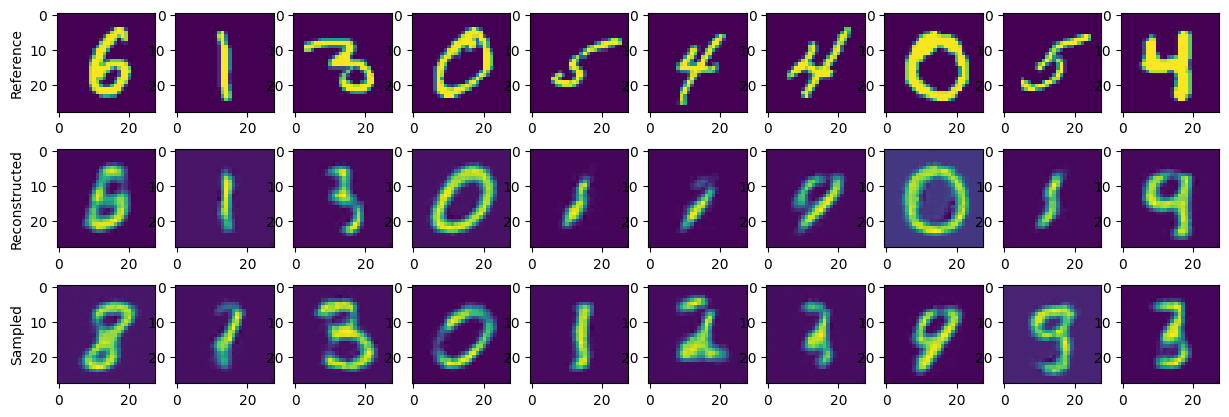

In [ ]:
fig, ax = plt.subplots(3, 10, figsize=(15, 5))
batch = batches[0]
inp_batch = torch.from_numpy(batch).type(torch.FloatTensor)
inp_batch = inp_batch.permute(0, 3, 1, 2)

reconstructions, encoded_mean, encoded_var, reparametrized = model.forward(inp_batch)
random_samples = np.random.normal(loc = 0.0, scale=0.9, size=(40, latent_dims))

print(random_samples.shape)
sampled_random_images = model.decoder(torch.from_numpy(random_samples).type(torch.FloatTensor))

for k in range(10):
    pannel_0 = ax[0][k].imshow(np.squeeze(batch[k+10]))
    pannel_1 = ax[1][k].imshow(np.squeeze(reconstructions[k+10].numpy()))
    pannel_2 = ax[2][k].imshow(np.squeeze(sampled_random_images[k+1].numpy()))

ax[0][0].set_ylabel('Reference')
ax[1][0].set_ylabel('Reconstructed')
ax[2][0].set_ylabel('Sampled')
